In [1]:
%pylab inline
%matplotlib inline
import pandas as pd
import json
import seaborn
import boto
import matplotlib.pyplot as plt
import numpy as np
import os, fnmatch

from IPython.core.display import HTML

css ="""
body {
    margin: 0;
    font-family: Helvetica;
}
table.dataframe {
    border-collapse: collapse;
    border: none;
}
table.dataframe tr {
    border: none;
}
table.dataframe td, table.dataframe th {
    margin: 0;
    border: 1px solid white;
    padding-left: 0.25em;
    padding-right: 0.25em;
}
table.dataframe th:not(:empty) {
    background-color: #fec;
    text-align: left;
    font-weight: normal;
}
table.dataframe tr:nth-child(2) th:empty {
    border-left: none;
    border-right: 1px dashed #888;
}
table.dataframe td {
    border: 2px solid #ccf;
    background-color: #f4f4ff;
}"""

HTML('<style>{}</style>'.format(css))

Populating the interactive namespace from numpy and matplotlib


/Users/mkjaiswa/anaconda/lib/python2.7/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


In [2]:
df_tags = pd.read_json('tags.json')
df_tags_by_rows = df_tags.T

In [3]:
# %cd C:\Users\Karunakaran\Desktop\Capstone
# Data = 'C:\Users\Karunakaran\Desktop\Capstone\tags.json'
# df_tags = pd.read_json('tags.json')

# %cd C:\Users\Karunakaran\Desktop\Capstone\Data
# targetdir = 'C:\Users\Karunakaran\Desktop\Capstone\Data'

In [4]:
# Karuna

targetdir = 'data'

#filelist = os.listdir(targetdir)
filelist = fnmatch.filter(os.listdir(targetdir), '*.json')

print filelist
df_json  = pd.DataFrame()



for f in filelist:
    f = targetdir +'/'+ f

    df = pd.read_json(f,orient='split')
    df_json = df_json.append(df,ignore_index=True)
    
df_template = pd.DataFrame(pd.DataFrame(df_tags.T['template'].reset_index()))
df_json_temp = pd.merge(df_json,df_template,left_on='sensor_id',right_on='index')[['sensor_id','template','room','values','sensor_value']]

['DF_00_split0.json', 'DF_00_split1.json', 'DF_00_split2.json', 'DF_00_split3.json', 'DF_00_split4.json', 'DF_00_split5.json', 'DF_00_split6.json', 'DF_00_split7.json']


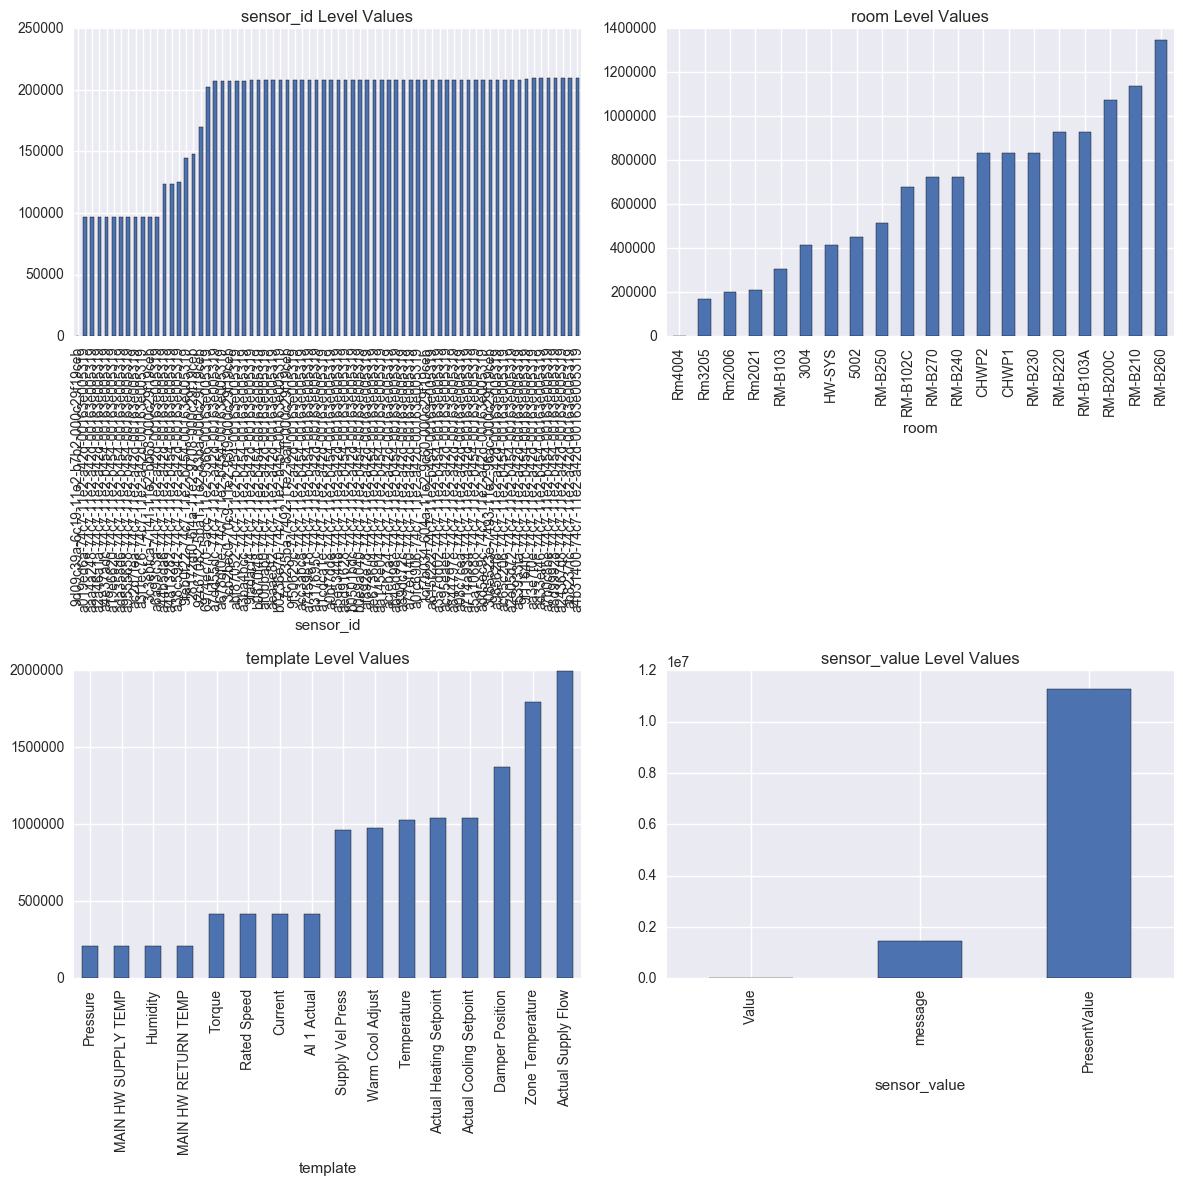

In [5]:
# Karuna

fig, axes = plt.subplots(figsize=(12,12),nrows=2, ncols=2)
df_plt = df_json_temp[['sensor_id','values']].groupby(['sensor_id']).count().sort_values(['values'],ascending=True)
df_plt.plot(kind = 'bar',title='%s Level Values' %('sensor_id'),legend=False,ax=axes[0,0])     
df_plt = df_json_temp[['room','values']].groupby(['room']).count().sort_values(['values'],ascending=True)
df_plt.plot(kind = 'bar',title='%s Level Values' %('room'),legend=False,ax=axes[0,1])     
df_plt = df_json_temp[['template','values']].groupby(['template']).count().sort_values(['values'],ascending=True)
df_plt.plot(kind = 'bar',title='%s Level Values' %('template'),legend=False,ax=axes[1,0])     
df_plt = df_json_temp[['sensor_value','values']].groupby(['sensor_value']).count().sort_values(['values'],ascending=True)
df_plt.plot(kind = 'bar',title='%s Level Values' %('sensor_value'),legend=False,ax=axes[1,1])     
plt.tight_layout()

In [6]:

## Manoj Code
df_tags_by_rows.head(1)

,contexts,name,network,paging,sensorpoints,template,total,uri
000581ec-54ef-4a5f-ae10-706817b7efe3,"[{u'tag': u'EBU3B', u'id': 155971, u'keyword':...",Average Supply Flow EBU3B RM-3xxx,BACNET,"{u'limit': 1000, u'offset': 0}","[{u'from_template': True, u'update_period': 0,...",Average Supply Flow,5,https://bd-datas1.ucsd.edu/admin/api/sensors/0...


In [7]:
df_tags_by_rows.name.str.split('-').map(lambda x:x[-1])

000581ec-54ef-4a5f-ae10-706817b7efe3                                         3xxx
00138452-8623-11e3-9443-00163e005319                            Unreliable Sensor
0017902c-74c9-11e2-b454-00163e005319                             Occupied Command
001a5e8e-77de-11e2-bad4-00163e005319                             Supply Vel Press
001b6972-77df-11e2-83c4-00163e005319                             Warm/Cool Adjust
001bcf80-74c8-11e2-a42d-00163e005319                      Actual Cooling Setpoint
0020605e-3773-11e3-9be2-00163e005319                         Occupant Information
0023ced6-1726-4f7c-b5c7-9c7bd01de974                                         1xxx
00269112-1d9f-4035-ae46-1874b7c0a54a                Aura Presence Sensor CSE 2150
00331d28-862b-11e3-88a2-00163e005319                                        Stuck
00341b10-f599-11e2-b6b7-00163e005319                        HVAC Zone Information
0034d026-8628-11e3-9443-00163e005319                       Setpoint|Command Error
0035614c-862a-11

In [8]:
dict_col = df_tags_by_rows.pop('contexts')
df_contexts = pd.DataFrame(dict_col)

dict_col = df_contexts.pop('contexts')
df_contexts = pd.concat([df_contexts, dict_col.apply(pd.Series)], axis=1)
df_contexts = pd.DataFrame(df_contexts.stack())

df_contexts.columns = ['inner']
dict_col = df_contexts.pop('inner')
df_contexts = pd.concat([df_contexts, dict_col.apply(pd.Series)], axis=1)
df_contexts_flat = df_contexts.reset_index()

df_contexts_flat.head(5)

,level_0,level_1,id,keyword,tag,uri
0,000581ec-54ef-4a5f-ae10-706817b7efe3,0,155971,building,EBU3B,/admin/api/contexts/155971
1,000581ec-54ef-4a5f-ae10-706817b7efe3,1,2,campus,Main,/admin/api/contexts/2
2,000581ec-54ef-4a5f-ae10-706817b7efe3,2,156189,floor,Flr-3,/admin/api/contexts/156189
3,000581ec-54ef-4a5f-ae10-706817b7efe3,3,1,institution,UCSD,/admin/api/contexts/1
4,000581ec-54ef-4a5f-ae10-706817b7efe3,4,157430,room,RM-3xxx,/admin/api/contexts/157430


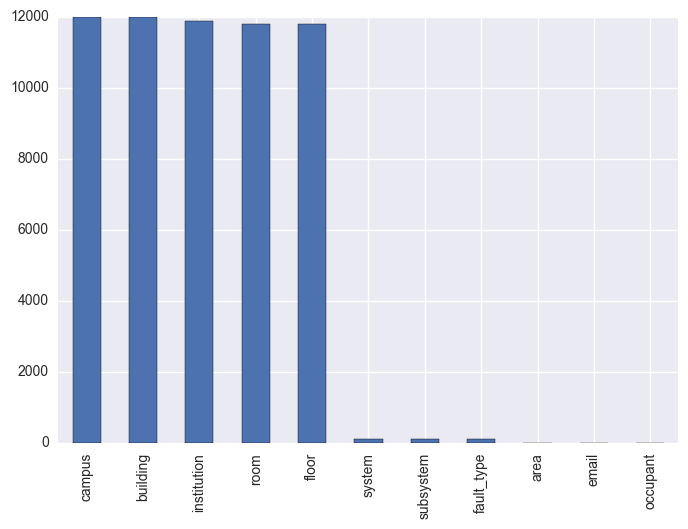

In [9]:
df_contexts_flat.keyword.value_counts().plot(kind='bar')

# Sensorpoints

In [10]:
dict_col = df_tags_by_rows.pop('sensorpoints')
df_sensorpoints = pd.DataFrame(dict_col)


dict_col = df_sensorpoints.pop('sensorpoints')
df_sensorpoints = pd.concat([df_sensorpoints, dict_col.apply(pd.Series)], axis=1)
df_sensorpoints = pd.DataFrame(df_sensorpoints.stack())


df_sensorpoints.columns = ['sensor_inner']
dict_col = df_sensorpoints.pop('sensor_inner')
df_sensorpoints = pd.concat([df_contexts, dict_col.apply(pd.Series)], axis=1)
df_sensorpoints_flat = df_sensorpoints.reset_index()

dict_col = df_sensorpoints_flat.pop('timeseries_span')
df_sensorpoints_flat = pd.concat([df_sensorpoints_flat, dict_col.apply(pd.Series)], axis=1)
#df_sensorpoints_flat = pd.DataFrame(df_sensorpoints_flat.stack())

In [11]:
df_sensorpoints_flat.head(2)

,level_0,level_1,id,keyword,tag,uri,active,created_time,data_type,description,...,readonly,shorthand_unit,timeseries_type,type,unit,update_period,uri,0,begin,end
0,000581ec-54ef-4a5f-ae10-706817b7efe3,0,155971.0,building,EBU3B,/admin/api/contexts/155971,True,2014-08-19T20:56:32+00:00,int,PresentValue,...,False,None,continuous,PresentValue,None,0.0,/admin/api/sensors/000581ec-54ef-4a5f-ae10-706...,NaN,2014-08-19T20:56:32+00:00,2015-12-23T02:18:43+00:00
1,000581ec-54ef-4a5f-ae10-706817b7efe3,1,2.0,campus,Main,/admin/api/contexts/2,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [12]:
cnt_sensor = len(df_sensorpoints_flat.level_0.unique())
cnt_room= df_sensorpoints_flat['tag'].loc[df_sensorpoints_flat['keyword'] == 'room'].nunique()
cnt_bldg= df_sensorpoints_flat['tag'].loc[df_sensorpoints_flat['keyword'] == 'building'].nunique()
df_sensorpoints_flat['tag'].loc[df_sensorpoints_flat['keyword'] == 'institution'].unique()

array([u'UCSD', u'Test_Institution', u'Bizwack Institute'], dtype=object)

In [13]:
df_data = pd.DataFrame({'no_of_sensor':[cnt_sensor],'no_of_room':[cnt_room],'no_of_building':[cnt_bldg]})
df_data


,no_of_building,no_of_room,no_of_sensor
0,7,734,11992


# Contexts

In [14]:
dict_col = df_sensorpoints.pop('timeseries_span')
pd.concat([df_sensorpoints, dict_col.apply(pd.Series)], axis=1)

dict_col = df_sensorpoints.pop('latest_datapoint')
pd.concat([df_sensorpoints, dict_col.apply(pd.Series)], axis=1)

#pd.concat([df_sensorpoints, dict_col.apply(pd.Series)], axis=1)

df_tags.iloc[[5]].T

,template
000581ec-54ef-4a5f-ae10-706817b7efe3,Average Supply Flow
00138452-8623-11e3-9443-00163e005319,Unreliable Sensor
0017902c-74c9-11e2-b454-00163e005319,Occupied Command
001a5e8e-77de-11e2-bad4-00163e005319,Supply Vel Press
001b6972-77df-11e2-83c4-00163e005319,Warm Cool Adjust
001bcf80-74c8-11e2-a42d-00163e005319,Actual Cooling Setpoint
0020605e-3773-11e3-9be2-00163e005319,Occupant Information
0023ced6-1726-4f7c-b5c7-9c7bd01de974,Average Floor Cooling PID5
00269112-1d9f-4035-ae46-1874b7c0a54a,ZigBee Presence Sensor
00331d28-862b-11e3-88a2-00163e005319,Stuck


In [15]:
df1 = pd.read_json('data/DF_00_split3.json', orient = 'split')
df1.head()

,values,sensor_value,room,sensor_id
2015-03-05 00:35:11,72.79,PresentValue,RM-B260,acc3abc8-74c7-11e2-b454-00163e005319
2013-07-11 11:28:45,58.66,PresentValue,RM-B260,acc3abc8-74c7-11e2-b454-00163e005319
2013-08-17 17:19:03,57.45,PresentValue,RM-B260,acc3abc8-74c7-11e2-b454-00163e005319
2013-09-20 13:30:24,50.32,PresentValue,RM-B260,acc3abc8-74c7-11e2-b454-00163e005319
2014-03-27 22:29:54,50.17,PresentValue,RM-B260,acc3abc8-74c7-11e2-b454-00163e005319


In [24]:
df2 = pd.read_json('data/DF_00_split1.json', orient='split')
df2.head()

,values,sensor_value,room,sensor_id
2014-07-22 10:44:44,-1.24,PresentValue,RM-B200C,9feb0f22-74c7-11e2-b454-00163e005319
2015-03-08 22:07:15,-0.44,PresentValue,RM-B200C,9feb0f22-74c7-11e2-b454-00163e005319
2013-08-03 18:15:29,0.75,PresentValue,RM-B200C,9feb0f22-74c7-11e2-b454-00163e005319
2013-07-21 19:14:14,0.00,PresentValue,RM-B200C,9feb0f22-74c7-11e2-b454-00163e005319
2013-08-09 21:46:51,2.96,PresentValue,RM-B200C,9feb0f22-74c7-11e2-b454-00163e005319


In [16]:
df_1 = pd.read_json('data/DF_00_split0.json', orient='split')
df_2 = pd.read_json('data/DF_00_split3.json', orient='split')
df_3 = pd.read_json('data/DF_00_split4.json', orient='split')
df_4 = pd.read_json('data/DF_00_split5.json', orient='split')
df_5 = pd.read_json('data/DF_00_split6.json', orient='split')

In [ ]:
df_all = pd.concat([df_1, df_2, df_3, df_4, df_5])
df_all.head()

In [42]:
#df_all['values'].hist(bins=20)

In [43]:
(df2['values'] < 0).sum() *1.0 / df2.sensor_value.count()

0.1970344234880505